In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
from PIL import Image
from tensorflow.keras.preprocessing import image
import pandas as pd

# Load all saved models
fibrosis_model = load_model('D:/PATENT/Model_testing/fibrosis_modified_model25.h5')
inflammation_model = load_model('D:/PATENT/Model_testing/inflam_modified25.h5')
ballooning_model = load_model('D:/PATENT/Model_testing/model_modified_ballooning25.h5')
steatosis_model = load_model('D:/PATENT/Model_testing/steatosis_modified15.h5')

# Function to display images
def show_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to preprocess and predict using the fibrosis model (Masson’s Trichome stained images)
def predict_fibrosis(image_path, model):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict using the fibrosis model
    preds = model.predict(x)
    max_prob_index = np.argmax(preds)
    
    # NASH score mapping for fibrosis
    fibrosis_conditions = {
        0: "Stage 0: No fibrosis",
        1: "Stage 1: Zone 3 perisinusoidal fibrosis (Mild - 1a, Moderate - 1b, Portal/periportal - 1c)",
        2: "Stage 2: Perisinusoidal and portal/periportal fibrosis",
        3: "Stage 3: Bridging fibrosis",
        4: "Stage 4: Cirrhosis"
    }
    
    fibrosis_condition = fibrosis_conditions[max_prob_index]
    print('Predicted Fibrosis Score:', fibrosis_condition)
    return max_prob_index

# Function to preprocess and predict using the inflammation, ballooning, and steatosis models (H&E stained images)
def predict_he_stained(image_path, model, model_type):
        
    # Define score mappings
    if model_type == 'inflammation':
        inflammation_scores = {
            0: "0: No inflammatory foci per 200×field",
            1: "1: <2 foci or 2-4 foci per 200×field",
            2: "2: >4 foci per 200×field",
            3: "4: >4 foci per 200×field"
        }
        
        img = Image.open(image_path)
        img = img.resize((299, 299), Image.ANTIALIAS)  # Resize the image to match model's input
        img_array = np.array(img) / 255.0  # Rescale the image
        img_array = img_array[np.newaxis, ...]  # Add batch dimension

        # Predict the class
        prediction = model.predict(img_array)
        max_prob_index = np.argmax(prediction)
        
        print('Predicted Inflammation Score:', inflammation_scores[max_prob_index])
        return max_prob_index

    elif model_type == 'steatosis':
        steatosis_scores = {
            0: "0: < 5% steatosis area",
            1: "1: 5–33% steatosis area",
            2: "2: 33–66% steatosis area",
            3: "3: >66% steatosis area"
        }
        img = Image.open(image_path)
        img = img.resize((299, 299), Image.ANTIALIAS)  # Resize the image to match model's input
        img_array = np.array(img) / 255.0  # Rescale the image
        img_array = img_array[np.newaxis, ...]  # Add batch dimension

        # Predict the class
        prediction = model.predict(img_array)
        max_prob_index = np.argmax(prediction)
        print('Predicted Steatosis Score:', steatosis_scores[max_prob_index])
        return max_prob_index

    elif model_type == 'ballooning':
        # For binary classification (ballooning)
        pred_class=0
        #ballooning_scores = {
        #    0: "0: Ballooning absent",
        #    1: "1: Few ballooned",
        #    2: "2: Many ballooned"
        #}
        img = image.load_img(image_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Create a batch
        img_array /= 255.0  # Normalize the image
        preds = model.predict(img_array)
        if preds[0][0] > 0.5:
            pred_class=1
            print('Predicted Ballooning Score: 1: Ballooning Present')
        else:
            pred_class=0
            print('Predicted Ballooning Score: 0: Ballooning Absent')
        return pred_class

# Determine NASH condition based on NASH score
def determine_nash_condition(nash_score):
    if nash_score < 3:
        return "NASH Condition: Not NASH"
    elif nash_score >= 5:
        return "NASH Condition: NASH"
    else:
        return "NASH Condition: Borderline NASH"

# Main function to handle predictions for the provided images
def predict_all(fibrosis_image_path, he_image_path):
    print("\nProcessing Fibrosis (Masson’s Trichome stained image):")
    show_image(fibrosis_image_path)
    fibrosis_score = predict_fibrosis(fibrosis_image_path, fibrosis_model)
    
    print("\nProcessing H&E stained image (Inflammation, Ballooning, Steatosis):")
    show_image(he_image_path)
    
    print("\nInflammation Prediction:")
    inflammation_score = predict_he_stained(he_image_path, inflammation_model, 'inflammation')
    
    print("\nBallooning Prediction:")
    ballooning_score = predict_he_stained(he_image_path, ballooning_model, 'ballooning')
    
    print("\nSteatosis Prediction:")
    steatosis_score = predict_he_stained(he_image_path, steatosis_model, 'steatosis')
    
    # Calculate NASH score
    nash_score = inflammation_score + ballooning_score + steatosis_score
    nash_condition = determine_nash_condition(nash_score)
    
    # Display final NASH score and conditions
    print(f"\nFinal NASH Score: {nash_score}")
    print(nash_condition)
    return fibrosis_score, inflammation_score, ballooning_score, steatosis_score

In [4]:
for i, layer in enumerate(fibrosis_model.layers):
    print(f"Layer {i}: {layer.name}, Type: {type(layer).__name__}")



Layer 0: input_1, Type: InputLayer
Layer 1: conv1_pad, Type: ZeroPadding2D
Layer 2: conv1_conv, Type: Conv2D
Layer 3: conv1_bn, Type: BatchNormalization
Layer 4: conv1_relu, Type: Activation
Layer 5: pool1_pad, Type: ZeroPadding2D
Layer 6: pool1_pool, Type: MaxPooling2D
Layer 7: conv2_block1_1_conv, Type: Conv2D
Layer 8: conv2_block1_1_bn, Type: BatchNormalization
Layer 9: conv2_block1_1_relu, Type: Activation
Layer 10: conv2_block1_2_conv, Type: Conv2D
Layer 11: conv2_block1_2_bn, Type: BatchNormalization
Layer 12: conv2_block1_2_relu, Type: Activation
Layer 13: conv2_block1_0_conv, Type: Conv2D
Layer 14: conv2_block1_3_conv, Type: Conv2D
Layer 15: conv2_block1_0_bn, Type: BatchNormalization
Layer 16: conv2_block1_3_bn, Type: BatchNormalization
Layer 17: conv2_block1_add, Type: Add
Layer 18: conv2_block1_out, Type: Activation
Layer 19: conv2_block2_1_conv, Type: Conv2D
Layer 20: conv2_block2_1_bn, Type: BatchNormalization
Layer 21: conv2_block2_1_relu, Type: Activation
Layer 22: conv2

In [6]:
layer_weights = inflammation_model.layers[177].get_weights()  
if layer_weights:  
    print("Kernel shape:", layer_weights[0].shape)  
    print("Bias shape:", layer_weights[1].shape)    
else:
    print("This layer has no weights.")


Kernel shape: (1, 1, 64, 64)
Bias shape: (64,)


Please provide the path of image for the following: 

 1. Masson's Trichome stained liver biopsy image:  D:/DATASET/CNN/fibrosis/test/4/194_85_10.png

 2. H&E stained liver biopsy image:  D:/DATASET/CNN/steatosis/test/3/381_292_13.png

Please provide the ground truth scores based on the clinician's assessment.
1. Ground truth of Fibrosis score (0-4): 3
2. Ground truth of Inflammation score (0-2): 0
3. Ground truth of Ballooning score (0-1): 1
4. Ground truth of Steatosis score (0-3): 3
5. Ground truth of NASH score: 4

Processing Fibrosis (Masson’s Trichome stained image):


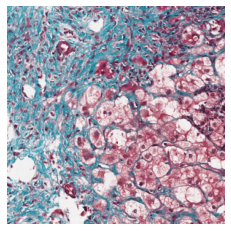

Predicted Fibrosis Score: Stage 4: Cirrhosis

Processing H&E stained image (Inflammation, Ballooning, Steatosis):


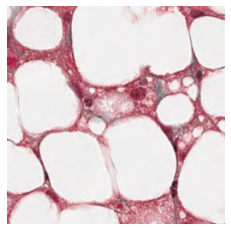


Inflammation Prediction:
Predicted Inflammation Score: 0: No inflammatory foci per 200×field

Ballooning Prediction:
Predicted Ballooning Score: 1: Ballooning Present

Steatosis Prediction:
Predicted Steatosis Score: 3: >66% steatosis area

Final NASH Score: 4
NASH Condition: Borderline NASH

--- Similarity Indices Assessment ---

  Score Type  Ground Truth  Predicted  Similarity Index (%)
    Fibrosis             3          4                  75.0
Inflammation             0          0                 100.0
  Ballooning             1          1                 100.0
   Steatosis             3          3                 100.0
        NASH             4          4                 100.0

--- Final Assessment ---
Final Similarity Index: 95.0%
Probability of Prediction Accuracy: 0.95

--- Detailed Assessment ---
Fibrosis Similarity Index is 75.0%: Moderate alignment, check for minor discrepancies.
Inflammation Similarity Index is 100.0%: Good alignment with clinician's assessment.
Ballooni

In [3]:
# Taking inputs from user in a structured format
print("Please provide the path of image for the following: ")
fibrosis_image_path = input("\n 1. Masson's Trichome stained liver biopsy image:  ")
he_image_path = input("\n 2. H&E stained liver biopsy image:  ")


# Function to calculate similarity index between ground truth and predicted score
def calculate_similarity_index(gt, pred):
    if max(gt, pred) == 0:
        return 100.0 if gt == pred else 0.0
    similarity = 100 * (1 - abs(gt - pred) / max(gt, pred))
    return round(similarity, 2)

# Function to calculate final similarity index and probability of accurate prediction
def calculate_final_similarity_and_probability(similarity_indices):
    final_similarity_index = sum(similarity_indices) / len(similarity_indices)
    probability_of_prediction = final_similarity_index / 100  # Convert to probability
    return round(final_similarity_index, 2), round(probability_of_prediction, 2)

# Taking inputs from user in a structured format
print("\nPlease provide the ground truth scores based on the clinician's assessment.")
ground_truth_scores = {
    "Fibrosis": int(input("1. Ground truth of Fibrosis score (0-4): ")),
    "Inflammation": int(input("2. Ground truth of Inflammation score (0-2): ")),
    "Ballooning": int(input("3. Ground truth of Ballooning score (0-1): ")),
    "Steatosis": int(input("4. Ground truth of Steatosis score (0-3): ")),
    "NASH": int(input("5. Ground truth of NASH score: ")),  # Direct input for NASH score
}

# Prediction by machine
fibrosis_score, inflammation_score, ballooning_score, steatosis_score = predict_all(fibrosis_image_path, he_image_path)

# Predicted scores from the models (these should be replaced with actual model predictions)
predicted_scores = {
    "Fibrosis": fibrosis_score,        # Example predicted score; replace with actual model output
    "Inflammation": inflammation_score,    # Replace with actual model output
    "Ballooning": ballooning_score,      # Replace with actual model output
    "Steatosis": steatosis_score,       # Replace with actual model output
}

# Calculate the predicted NASH score
predicted_scores["NASH"] = (
    predicted_scores["Inflammation"] +
    predicted_scores["Ballooning"] +
    predicted_scores["Steatosis"]
)

# Calculate individual similarity indices for each score
similarity_indices = {
    key: calculate_similarity_index(ground_truth_scores[key], predicted_scores[key])
    for key in ground_truth_scores
}

# Calculate final similarity index and probability
final_similarity_index, prediction_probability = calculate_final_similarity_and_probability(
    list(similarity_indices.values())
)

# Prepare data for tabulated output
data = {
    "Score Type": ["Fibrosis", "Inflammation", "Ballooning", "Steatosis", "NASH"],
    "Ground Truth": list(ground_truth_scores.values()),
    "Predicted": list(predicted_scores.values()),
    "Similarity Index (%)": list(similarity_indices.values()),
}

# Create a DataFrame for better visualization
df = pd.DataFrame(data)

# Display the tabulated results
print("\n--- Similarity Indices Assessment ---\n")
print(df.to_string(index=False))

# Display final assessment
print("\n--- Final Assessment ---")
print(f"Final Similarity Index: {final_similarity_index}%")
print(f"Probability of Prediction Accuracy: {prediction_probability}")

# Detailed Assessment
print("\n--- Detailed Assessment ---")
for score, similarity in similarity_indices.items():
    if similarity >= 80:
        print(f"{score} Similarity Index is {similarity}%: Good alignment with clinician's assessment.")
    elif 50 <= similarity < 80:
        print(f"{score} Similarity Index is {similarity}%: Moderate alignment, check for minor discrepancies.")
    else:
        print(f"{score} Similarity Index is {similarity}%: Low alignment, consider revision.")


In [ ]:
#fibrosis_image_path = "D:/DATASET/CNN/fibrosis/test/4/194_85_10.png"
#he_image_path = "D:/DATASET/CNN/steatosis/test/3/381_292_13.png"

In [ ]:

'''
# Save and extract feature maps for future dashboard development
def extract_feature_maps(image_path, model, layer_name):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Create intermediate model to get feature maps
    feature_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = feature_model.predict(x)[0]
    
    # Visualize the first 15 feature maps
    visualize_feature_maps(feature_maps)

# Visualize feature maps (useful for future analysis and dashboard)
def visualize_feature_maps(feature_maps, num_features=15):
    fig, axes = plt.subplots(nrows=int(np.sqrt(num_features)), ncols=int(np.sqrt(num_features)), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_features:
            ax.imshow(feature_maps[:, :, i], cmap='viridis')
            ax.axis('off')
    plt.show()

# Example of feature extraction
extract_feature_maps(he_image_path, inflammation_model, 'conv2d_2')  # Customize the layer name based on model architecture
'''